In [49]:
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm
import scipy
import sys
import torch
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
from smoothing import GaussianSmoothing
import scipy
import seaborn as sns
import sklearn.metrics
sns.set()

In [34]:
def readT1(file):
    if file.endswith(".npy"):
        return np.load(file)[0]
    elif file.endswith(".nii"):
        return np.transpose(nib.load(file).get_fdata())/1000
    elif file.endswith(".dat"):
        return np.fromfile(file, dtype=np.float32).reshape(256,256,256)/1000
    else:
        return None
    
dataset = {
    "pred":{
        "Conventional ModelFit" : sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/acc_2min/T1_3_tv.nii")),
        #"Accelerated PCA DL" : sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_2min_*.npy")) ,
        #"Full PCA DL": sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_gt_*.npy")),
        #"Full Denoised DL": sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_9min_denoised_*.npy")),
        "Denoiser and T1 Predictor": sorted([file for file in glob("/study/mrphys/skunkworks/kk/T1/T1_*.npy") if len(file.split("_"))==2]),
        #"Denoised ModelFit": sorted(glob("/local/kk/denoised/*/T1_3.dat")),
        "T1 Denoiser": sorted(glob("/study/mrphys/skunkworks/kk/T1/T1_denoised_*.npy")),
    },
    "true": sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii")),
    "mask": sorted(glob('/scratch/mrphys/masks/*')),
}
    
def emptyDict(dataset=dataset):
    dictionary = {
        'mean':{
            "pred" : {
                pred:[] for pred in dataset["pred"].keys()
            },
            "true":[]
        },
        'std':{
            "pred" : {
                pred:[] for pred in dataset["pred"].keys()
            },
            "true":[]
        }
    }
    
    return dictionary 

In [35]:
T1Dict = {
    "CSF" : emptyDict(),
    "Gray Matter" : emptyDict(),
    "White Matter" : emptyDict(),
}

for i in tqdm(range(len(dataset["true"]))):
    ground_truth = readT1(dataset["true"][i])
    mask = np.load(dataset["mask"][i])
    T1Dict["CSF"]['mean']["true"].append(np.mean(ground_truth[mask==1]))
    T1Dict["Gray Matter"]['mean']["true"].append(np.mean(ground_truth[mask==2]))
    T1Dict["White Matter"]['mean']["true"].append(np.mean(ground_truth[mask==3]))
    T1Dict["CSF"]['std']["true"].append(np.std(ground_truth[mask==1]))
    T1Dict["Gray Matter"]['std']["true"].append(np.std(ground_truth[mask==2]))
    T1Dict["White Matter"]['std']["true"].append(np.std(ground_truth[mask==3]))
    for pred in dataset["pred"].keys():
        predictions = readT1(dataset["pred"][pred][i])
        T1Dict["CSF"]['mean']["pred"][pred].append(np.mean(predictions[mask==1]))
        T1Dict["Gray Matter"]['mean']["pred"][pred].append(np.mean(predictions[mask==2]))
        T1Dict["White Matter"]['mean']["pred"][pred].append(np.mean(predictions[mask==3]))
        T1Dict["CSF"]['std']["pred"][pred].append(np.std(predictions[mask==1]))
        T1Dict["Gray Matter"]['std']["pred"][pred].append(np.std(predictions[mask==2]))
        T1Dict["White Matter"]['std']["pred"][pred].append(np.std(predictions[mask==3]))

100%|███████████████████████████████████████████████████████████████████████████████████| 65/65 [01:21<00:00,  1.26s/it]


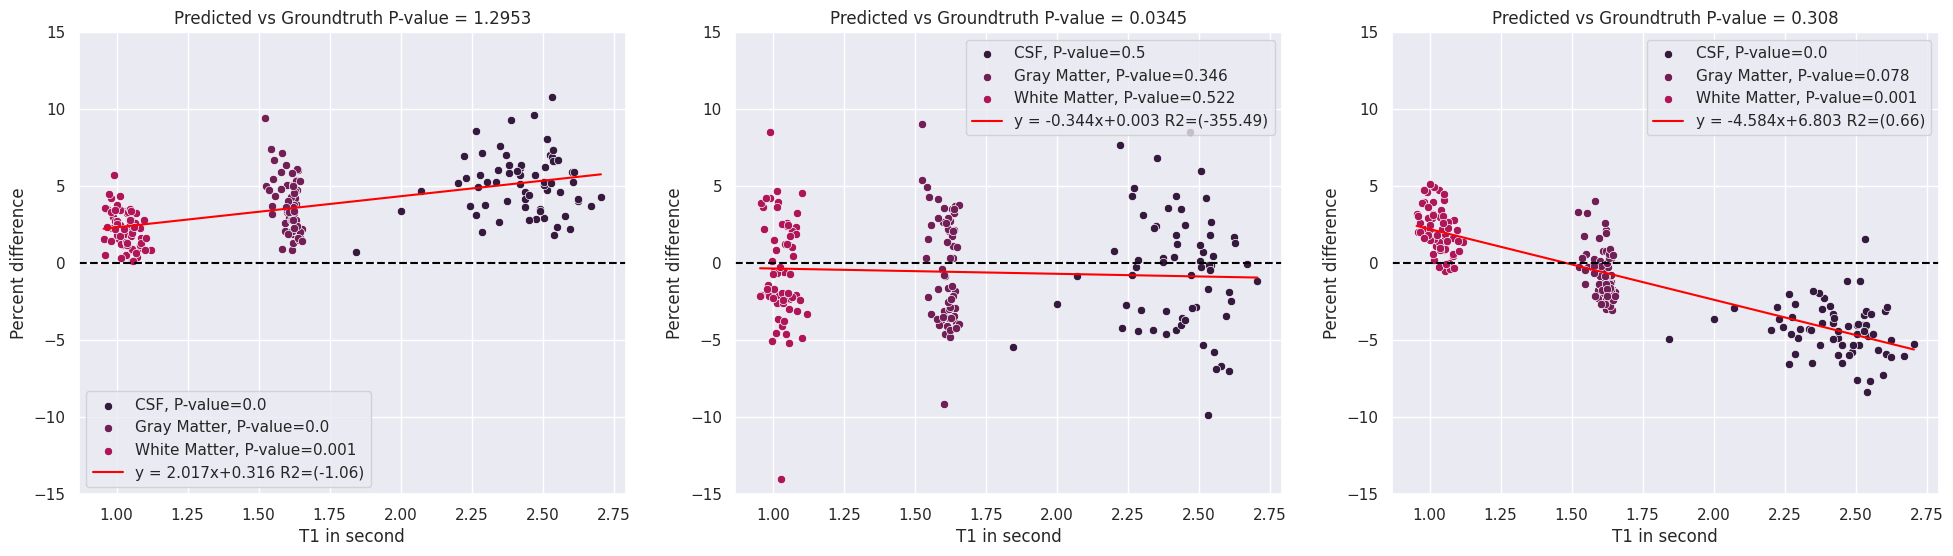

In [58]:
n = len(dataset["pred"].keys())

fig, ax = plt.subplots(1, n, figsize=(24, 2*n))
colors = sns.color_palette("rocket")

for i, predictedType in enumerate(dataset["pred"].keys()):
    
    allTrue = []
    allPred = []
    
    for j, tissueType in enumerate(T1DictMean.keys()):
        
        true = T1Dict[tissueType]['mean']["true"]
        pred = T1Dict[tissueType]['mean']["pred"][predictedType]
        allTrue += true
        allPred += pred
        percent_dif = 100*(np.array(pred)-np.array(true))/np.array(true)
        sns.scatterplot(ax=ax[i], x=true, y=percent_dif, color=colors[j], label=f'{tissueType}, P-value={round(scipy.stats.f_oneway(pred, true)[1], 3)}')
    
    percent_dif = 100*(np.array(allPred)-np.array(allTrue))/np.array(allTrue)
    m, c, r, p, std_err = scipy.stats.linregress(allTrue, percent_dif)
    x = np.linspace(np.min(allTrue), np.max(allTrue), 100)
    y = m*x+c
    r2 = sklearn.metrics.r2_score(m*np.array(allTrue)+c, percent_dif)
    ax[i].plot(x, y, color='red', label=f'y = {round(m,3)}x+{round(c,3)} R2=({round(r2,2)})')
    ax[i].axhline(0, linestyle="--", color='black')
    ax[i].set_title(f'Predicted vs Groundtruth P-value = {round(scipy.stats.f_oneway(allPred, allTrue)[0], 4)}') 
    ax[i].legend()
    ax[i].set_ylim([-15, 15])
    ax[i].set_xlabel('T1 in second') 
    ax[i].set_ylabel('Percent difference') 

plt.show()

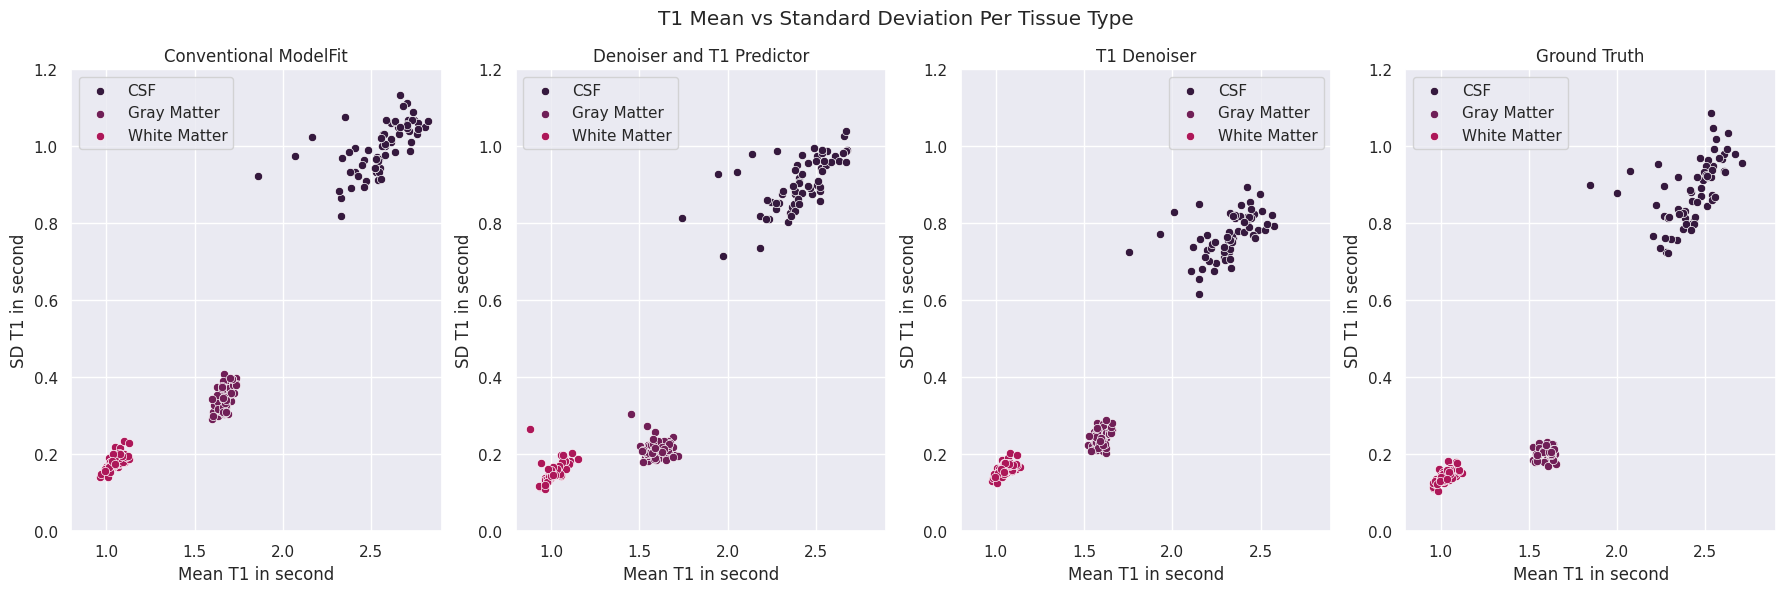

In [78]:
n = len(dataset["pred"].keys())

fig, ax = plt.subplots(1, n+1, figsize=(22, int(1.6*(n+1))))
colors = sns.color_palette("rocket")

for a in ax:
    a.set_ylim([0, 1.2])
    a.set_xlim([0.8, 2.9])
    a.set_xlabel('Mean T1 in second') 
    a.set_ylabel('SD T1 in second') 

for i, predictedType in enumerate(dataset["pred"].keys()):
    for j, tissueType in enumerate(T1DictMean.keys()):
        mean = T1Dict[tissueType]['mean']["pred"][predictedType]
        std = T1Dict[tissueType]['std']["pred"][predictedType]
        sns.scatterplot(ax=ax[i], x=mean, y=std, label=tissueType, color=colors[j])
    ax[i].set_title(predictedType)
    ax[i].legend()
    
for j, tissueType in enumerate(T1DictMean.keys()):
    mean = T1Dict[tissueType]['mean']["true"]
    std = T1Dict[tissueType]['std']["true"]
    sns.scatterplot(ax=ax[-1], x=mean, y=std, label=tissueType, color=colors[j])
ax[-1].set_title('Ground Truth')
ax[-1].legend()
fig.suptitle("T1 Mean vs Standard Deviation Per Tissue Type")
plt.show()

In [ ]:
def emptyDict(dataset=dataset):
    dictionary = {
        'mean':{
            "pred" : {
                pred:[] for pred in dataset["pred"].keys()
            },
            "true":[]
        },
        'std':{
            "pred" : {
                pred:[] for pred in dataset["pred"].keys()
            },
            "true":[]
        }
    }
    
    return dictionary 

T1DictAll = {
    "CSF" : emptyDict(),
    "Gray Matter" : emptyDict(),
    "White Matter" : emptyDict(),
}

for i in tqdm(range(len(dataset["true"]))):
    ground_truth = readT1(dataset["true"][i])
    mask = np.load(dataset["mask"][i])
    T1Dict["CSF"]['mean']["true"].append(np.mean(ground_truth[mask==1]))
    T1Dict["Gray Matter"]['mean']["true"].append(np.mean(ground_truth[mask==2]))
    T1Dict["White Matter"]['mean']["true"].append(np.mean(ground_truth[mask==3]))
    T1Dict["CSF"]['std']["true"].append(np.std(ground_truth[mask==1]))
    T1Dict["Gray Matter"]['std']["true"].append(np.std(ground_truth[mask==2]))
    T1Dict["White Matter"]['std']["true"].append(np.std(ground_truth[mask==3]))
    for pred in dataset["pred"].keys():
        predictions = readT1(dataset["pred"][pred][i])
        T1Dict["CSF"]['mean']["pred"][pred].append(np.mean(predictions[mask==1]))
        T1Dict["Gray Matter"]['mean']["pred"][pred].append(np.mean(predictions[mask==2]))
        T1Dict["White Matter"]['mean']["pred"][pred].append(np.mean(predictions[mask==3]))
        T1Dict["CSF"]['std']["pred"][pred].append(np.std(predictions[mask==1]))
        T1Dict["Gray Matter"]['std']["pred"][pred].append(np.std(predictions[mask==2]))
        T1Dict["White Matter"]['std']["pred"][pred].append(np.std(predictions[mask==3]))